In [1]:
# !pip install catboost optuna







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00









     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.8 MB/s eta 0:00:00






























     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.1 MB/s eta 0:00:00



























     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00















































In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, classification_report

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# import optuna

from scipy.spatial.distance import pdist, squareform

import pickle

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from scipy.sparse import csr_matrix, coo_matrix


In [2]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

Resources:  https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

### Load and Clean Data

#### General

In [24]:
datapath = './data/' # local, sagemaker
# datapath = r'/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/' # colab
# datapath = r'/kaggle/input/' # kaggle

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_test_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

- No missing data to fill

In [40]:
def preprocess(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

def preprocess_autoencode(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

def preprocess_NN_cat2vec(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features_indices.append(i)
            
    categorical_features = []
    for colname,dtype in zip(df_features.columns,df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features.append(colname)

    geo_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
    df_features = pd.get_dummies(df_features,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)
    return df_features, categorical_features

def preprocess_target_encode(df_features):
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features_indices.append(i)
            
    categorical_features = []
    for colname,dtype in zip(df_features.columns,df_features.dtypes):
        if dtype in ['int64','object']:
            categorical_features.append(colname)

    geo_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
    df_features = pd.get_dummies(df_features,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)
    return df_features, categorical_features

In [41]:
# Prep data for target_encode
geo_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
df_train_features, categorical_features = preprocess_target_encode(df_train_features_raw)
df_test_features,_ = preprocess_target_encode(df_test_features_raw)

non_geo_features = [col for col in df_train_features.columns if not (col in geo_features)]
numerical_features = ['count_floors_pre_eq','age', 'area_percentage','height_percentage','count_families']

all_geos = pd.concat([df_train_features[geo_features],df_test_features[geo_features]])
all_geos = all_geos.nunique()

X_train_or, X_test_or, y_train_or, y_test_or = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)

# # Standardize numerical features
# scaler = StandardScaler()
# X_train_or[non_geo_features] = scaler.fit_transform(X_train_or[non_geo_features])
# X_test_or[non_geo_features] = scaler.transform(X_test_or[non_geo_features])

In [27]:
all_geos = pd.concat([df_train_features_raw[geo_features],df_test_features_raw[geo_features]])

#### Target Encode

In [42]:
X_train = X_train_or.copy()
X_test = X_test_or.copy()
y_train = y_train_or.copy()
y_test = y_test_or.copy()
target = 'damage_grade'

full_train = pd.concat([X_train,y_train],axis=1)
# full_test = pd.concat([X_test,y_test],axis=1)

In [114]:
# Function to perform target encoding with smoothing for a given column against the target_column in a DataFrame
def target_encode_smooth(df, target_column, column, smoothing=1):
    """
    Perform target encoding with smoothing for a given column against the target_column in a DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame containing both target_column and column.
    target_column (str): The name of the target column (to be encoded against).
    column (str): The name of the column to encode.
    smoothing (float): The smoothing parameter.
    
    Returns:
    dict: A dictionary mapping each unique value in 'column' to its smoothed target-encoded value.
    """
    # Calculate the global mean of the target variable
    global_mean = df[target_column].mean()
    
    # Calculate the number of values and the mean of each group
    agg = df.groupby(column)[target_column].agg(['mean', 'count'])
    counts = agg['count']
    means = agg['mean']
    
    # Compute the smoothed means
    smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
    
    # Return the mapping as a dictionary
    return smooth.to_dict()

# Apply target encoding with smoothing for the categorical column against each target column
categorical_column = 'geo_level_3_id'
target_columns = [col for col in full_train.columns if not (col in geo_features + numerical_features)]
# target_columns = ['damage_grade']
encoded_maps = {}

# Smoothing parameter
smoothing = 100 # You can adjust this parameter

# Iterate over each target column and perform target encoding with smoothing
for target_column in target_columns:
    encoded_maps[target_column] = target_encode_smooth(full_train, target_column, categorical_column, smoothing)

# Optionally, if you want to apply the encoding to your DataFrame
for target_column in target_columns:
    full_train[f'{categorical_column}_encoded_{target_column}'] = full_train[categorical_column].map(encoded_maps[target_column])

In [115]:
geo_targ_encode = pd.DataFrame(encoded_maps)
geo_targ_encode.rename(columns={col:'geo3_'+col for col in geo_targ_encode.columns},inplace=True)
geo_targ_encode = geo_targ_encode.reset_index()
geo_targ_encode.rename(columns={'index':'geo_level_3_id'},inplace=True)

In [116]:
# Add encoding to features
X_train_geo_encode = X_train.merge(geo_targ_encode,on='geo_level_3_id',how='left')
X_train_geo_encode.drop(columns=['geo_level_3_id'],inplace=True)
X_test_geo_encode = X_test.merge(geo_targ_encode,on='geo_level_3_id',how='left')
X_test_geo_encode.drop(columns=['geo_level_3_id'],inplace=True)

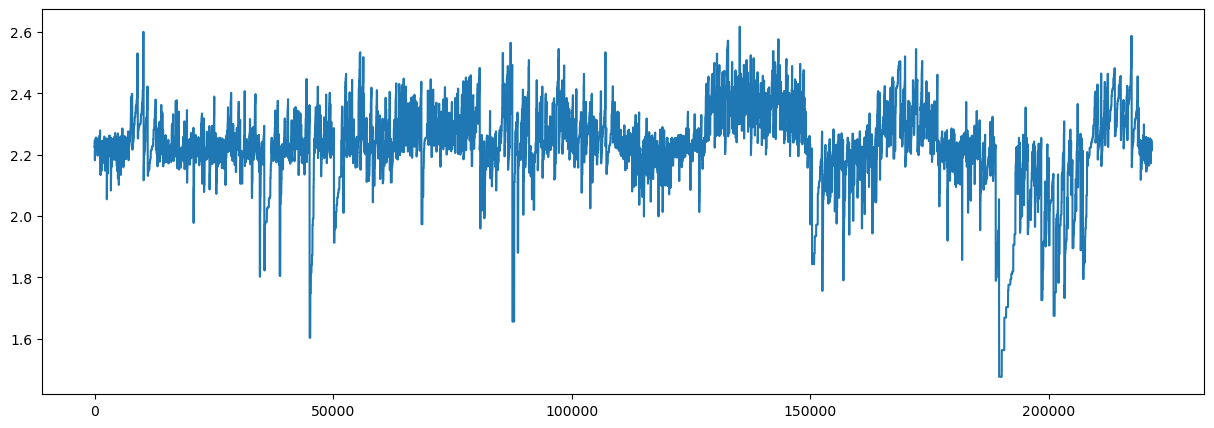

In [117]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(X_train_geo_encode.sort_values(['geo_level_1_id','geo_level_2_id','geo3_damage_grade']).reset_index(drop=True)['geo3_damage_grade']);

## CatBoost

### Use learnt embedding

In [118]:
pd.set_option('display.max_info_columns', 180)
X_train_geo_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221510 entries, 0 to 221509
Data columns (total 113 columns):
 #    Column                                         Non-Null Count   Dtype  
---   ------                                         --------------   -----  
 0    geo_level_1_id                                 221510 non-null  int64  
 1    geo_level_2_id                                 221510 non-null  int64  
 2    count_floors_pre_eq                            221510 non-null  float64
 3    age                                            221510 non-null  float64
 4    area_percentage                                221510 non-null  float64
 5    height_percentage                              221510 non-null  float64
 6    count_families                                 221510 non-null  float64
 7    land_surface_condition_o                       221510 non-null  bool   
 8    land_surface_condition_t                       221510 non-null  bool   
 9    foundation_type_i       

In [119]:
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train_geo_encode.dtypes):
    if dtype in ['int64','object','bool']:
        categorical_features_indices.append(i)
categorical_features = []
for colname,dtype in zip(X_train_geo_encode.columns,X_train_geo_encode.dtypes):
    if dtype in ['int64','object','bool']:
        categorical_features.append(colname)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train_geo_encode, label=y_train, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test_geo_encode, label=y_test, cat_features=categorical_features_indices)

In [120]:
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE')

# Grid search training
grid = {'iterations': [200],
        'learning_rate': [0.1],
        'depth': [6],
        'l2_leaf_reg': [0.2]}
model.grid_search(grid, train_dataset)

# Evaluation
pred = model.predict(X_test_geo_encode)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(pred)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0:	learn: 2.1015984	test: 2.0965308	best: 2.0965308 (0)	total: 324ms	remaining: 1m 4s
1:	learn: 1.9050036	test: 1.8999735	best: 1.8999735 (1)	total: 599ms	remaining: 59.3s
2:	learn: 1.7285089	test: 1.7235579	best: 1.7235579 (2)	total: 865ms	remaining: 56.8s
3:	learn: 1.5706360	test: 1.5657562	best: 1.5657562 (3)	total: 1.1s	remaining: 54.1s
4:	learn: 1.4294429	test: 1.4246912	best: 1.4246912 (4)	total: 1.4s	remaining: 54.6s
5:	learn: 1.3037186	test: 1.2991169	best: 1.2991169 (5)	total: 1.64s	remaining: 53.2s
6:	learn: 1.1921805	test: 1.1876968	best: 1.1876968 (6)	total: 1.91s	remaining: 52.8s
7:	learn: 1.0932321	test: 1.0889304	best: 1.0889304 (7)	total: 2.18s	remaining: 52.4s
8:	learn: 1.0059883	test: 1.0019116	best: 1.0019116 (8)	total: 2.45s	remaining: 52.1s
9:	learn: 0.9279606	test: 0.9241212	best: 0.9241212 (9)	total: 2.74s	remaining: 52s
10:	learn: 0.8606578	test: 0.8570010	best: 0.8570010 (10)	total: 3.02s	remaining: 51.9s
11:	learn: 0.8014011	test: 0.7980224	best: 0.7980224 (11

0.743521526694124

In [61]:
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE')

# Grid search training
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 2.2553110	test: 2.2502567	best: 2.2502567 (0)	total: 105ms	remaining: 10.3s
1:	learn: 2.1912716	test: 2.1861707	best: 2.1861707 (1)	total: 219ms	remaining: 10.7s
2:	learn: 2.1292924	test: 2.1241936	best: 2.1241936 (2)	total: 334ms	remaining: 10.8s
3:	learn: 2.0696280	test: 2.0645217	best: 2.0645217 (3)	total: 504ms	remaining: 12.1s
4:	learn: 2.0111741	test: 2.0060658	best: 2.0060658 (4)	total: 630ms	remaining: 12s
5:	learn: 1.9548919	test: 1.9497672	best: 1.9497672 (5)	total: 734ms	remaining: 11.5s
6:	learn: 1.9000087	test: 1.8949505	best: 1.8949505 (6)	total: 825ms	remaining: 11s
7:	learn: 1.8472466	test: 1.8422020	best: 1.8422020 (7)	total: 926ms	remaining: 10.6s
8:	learn: 1.7961376	test: 1.7911380	best: 1.7911380 (8)	total: 1.06s	remaining: 10.7s
9:	learn: 1.7465190	test: 1.7415741	best: 1.7415741 (9)	total: 1.21s	remaining: 10.9s
10:	learn: 1.6986083	test: 1.6937158	best: 1.6937158 (10)	total: 1.44s	remaining: 11.6s
11:	learn: 1.6522907	test: 1.6474155	best: 1.6474155 (11

{'params': {'depth': 8,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [62]:
# Evaluation
pred = model.predict(X_test_geo_encode)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

Testing performance
RMSE: 0.44
R2: 0.47


In [63]:
# import pickle
# with open('earthquake_cb_model_1.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [64]:
pred_int = np.round(pred)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0.7441354787547005

In [68]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 0.20000000298023224,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount

<BarContainer object of 38 artists>

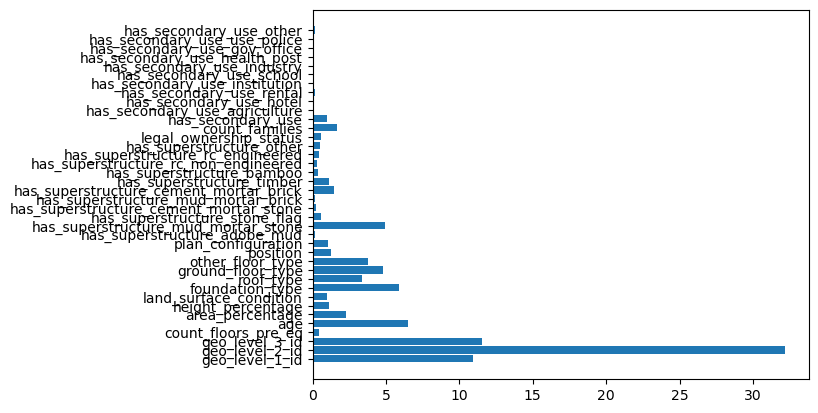

In [ ]:
# feature_importance_vals = model.get_feature_importance()
# plt.barh(X_train.columns,feature_importance_vals)


### OPTUNA

In [6]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
        'depth': trial.suggest_int('depth', 3, 10),
        'random_seed': 42,
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter
        'loss_function': 'RMSE',
        'od_type': 'Iter',
        'od_wait': 50,
        'task_type': 'GPU',  # Use GPU for training
        'verbose': False  # Disable CatBoost verbose output
    }

    model = cb.CatBoostRegressor(**params)
    model.fit(train_dataset, eval_set=val_dataset, early_stopping_rounds=50, verbose_eval=False)

    y_pred = model.predict(val_dataset)
    score = mean_squared_error(y_val, y_pred, squared=False)
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

[I 2024-06-20 00:31:27,101] A new study created in memory with name: no-name-ec61d895-1c52-4f26-9033-872d4b980ff8


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:32:03,759] Trial 0 finished with value: 0.4970125176108661 and parameters: {'iterations': 160, 'learning_rate': 0.006669755518856318, 'depth': 7, 'l2_leaf_reg': 83.38317923225196}. Best is trial 0 with value: 0.4970125176108661.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:32:23,851] Trial 1 finished with value: 0.4475284467535261 and parameters: {'iterations': 517, 'learning_rate': 0.06001707318708533, 'depth': 8, 'l2_leaf_reg': 0.00020695187983015833}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:32:47,005] Trial 2 finished with value: 0.4480076937361499 and parameters: {'iterations': 425, 'learning_rate': 0.041364305052773165, 'depth': 10, 'l2_leaf_reg': 0.0024890666749060692}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:10,722] Trial 3 finished with value: 0.5420428223065008 and parameters: {'iterations': 706, 'learning_rate': 0.0005739359709736625, 'depth': 8, 'l2_leaf_reg': 19.962838759027225}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:18,951] Trial 4 finished with value: 0.5895482111192502 and parameters: {'iterations': 221, 'learning_rate': 0.0004762801045277096, 'depth': 8, 'l2_leaf_reg': 20.704521766426264}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:27,200] Trial 5 finished with value: 0.45956202657429823 and parameters: {'iterations': 535, 'learning_rate': 0.023207225639048923, 'depth': 3, 'l2_leaf_reg': 0.06320062517442655}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:34,947] Trial 6 finished with value: 0.45509489145952464 and parameters: {'iterations': 249, 'learning_rate': 0.040999107520008536, 'depth': 6, 'l2_leaf_reg': 0.3647707766313438}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:50,909] Trial 7 finished with value: 0.4597167537828126 and parameters: {'iterations': 430, 'learning_rate': 0.00726393356433904, 'depth': 8, 'l2_leaf_reg': 0.0162411445823464}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:33:58,075] Trial 8 finished with value: 0.4576006175229995 and parameters: {'iterations': 264, 'learning_rate': 0.031181906098745958, 'depth': 5, 'l2_leaf_reg': 4.7939000201651754e-05}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:05,116] Trial 9 finished with value: 0.4536869033507849 and parameters: {'iterations': 449, 'learning_rate': 0.14437729793670398, 'depth': 3, 'l2_leaf_reg': 3.522010803785723}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:16,657] Trial 10 finished with value: 0.44831727583625347 and parameters: {'iterations': 936, 'learning_rate': 0.24530882427328932, 'depth': 10, 'l2_leaf_reg': 7.202291881562506e-08}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:23,575] Trial 11 finished with value: 0.45177698030126034 and parameters: {'iterations': 683, 'learning_rate': 0.4286877153038693, 'depth': 10, 'l2_leaf_reg': 4.013209502235e-05}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[I 2024-06-20 00:34:57,388] Trial 12 finished with value: 0.46156664667501546 and parameters: {'iterations': 653, 'learning_rate': 0.0035663829423760573, 'depth': 10, 'l2_leaf_reg': 0.0002644439196696404}. Best is trial 1 with value: 0.4475284467535261.


/tmp/ipykernel_34/3320020667.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),

/tmp/ipykernel_34/3320020667.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),  # L2 regularization parameter


[W 2024-06-20 00:35:06,498] Trial 13 failed with parameters: {'iterations': 349, 'learning_rate': 0.0764756880515819, 'depth': 9, 'l2_leaf_reg': 4.7108064491623973e-07} because of the following error: KeyboardInterrupt('').

Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial

    value_or_values = func(trial)

  File "/tmp/ipykernel_34/3320020667.py", line 16, in objective

    model.fit(train_dataset, eval_set=val_dataset, early_stopping_rounds=50, verbose_eval=False)

  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5827, in fit

    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,

  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 2400, in _fit

    self._train(

  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 1780, in _train

    self._object._train(trai

KeyboardInterrupt: 

In [7]:
# Load study
with open(datapath+'optuna_study.pkl', 'rb') as file:
    study = pickle.load(file)
    
# Print the best parameters and score
best_params = study.best_params
best_score = study.best_value

print('Best parameters found:')
print(best_params)
print('Best RMSE found: {:.4f}'.format(best_score))

# Train the final model with the best parameters on the entire dataset

final_train_pool = cb.Pool(X_train_or, y_train_or, cat_features=categorical_features_indices)
final_model = cb.CatBoostRegressor(**best_params, task_type='GPU', verbose=False)
final_model.fit(final_train_pool, verbose_eval=False)

# Evaluate on hold out
predictions = final_model.predict(X_test)

Best parameters found:

{'iterations': 987, 'learning_rate': 0.06594606333962763, 'depth': 10, 'l2_leaf_reg': 5.1486658327264455e-05}

Best RMSE found: 0.4434

Example predictions:

[2.08831371 2.68991622 2.69258255 ... 2.56914313 1.93965214 2.57058941]


In [8]:
pred_int = np.round(predictions)
# (pred_int == np.squeeze(y_test.to_numpy())).sum()/y_test.shape[0]
f1_score(y_test,pred_int,average='micro')
# f1_score(y_test,pred_int)

0.7476145404313014

<BarContainer object of 38 artists>

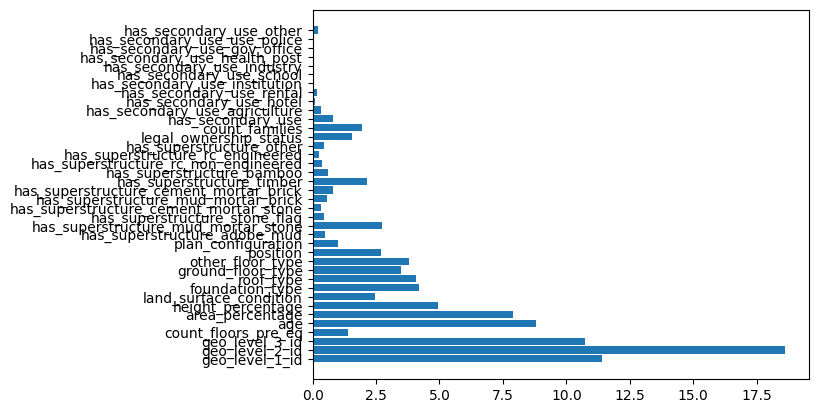

In [9]:
feature_importance_vals = final_model.get_feature_importance()
plt.barh(X_train.columns,feature_importance_vals)

In [ ]:
# model_filename = '/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/optuna_study.pkl'

# # Save the model to file
# with open(model_filename, 'wb') as f:
#     pickle.dump(study, f)

### AutoEncoder Enhanced